In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as LA
import math
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import spsolve, spsolve_triangular

# Timer
from timeit import default_timer as timer
# Visualisation libraries

## matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import rcParams
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# The Wave Equation in Time Domain

The wave equation in time domain can be stated as follows,
\begin{equation}
\frac{\partial^2 u}{\partial t^2}=c^2 \nabla^2 u+f,\qquad x\in \Omega \subset \mathbb{R}^d,~t\in(T_1,T_2]
\end{equation}
where $\Delta$ is *the Laplacian*, $f$ is a *forcing function* (for example our source) and $c$ is *the wave velocity* at which the time and spatially varying wave $u$ propagates.

## Second-Order Finite-Difference Methods for the Two Dimensional Wave Equation in Time Domain

A two-dimensional form of the wave equation presented can be found as follows,

\begin{align}
\begin{cases}
\frac{\partial^2 u}{\partial t^2} = c^2(x,y) \Delta u+f(x,y,t),&(x,y)\in I,~t\in(T_1,T_2],\\
u(x,y,T_1)=g(x,y),&(x,y)\in J,\\
\frac{\partial }{\partial t}u(x,y,T_1) = s(x,y),&(x,y)\in J,\\
u(a,y,t) = f_{a}(y,t),&y\in [c,d],~t \in[T_1,T_2],\\
u(b,y,t) = f_{b}(y,t),&y\in [c,d],~t \in[T_1,T_2],\\
u(x,c,t) = f_{c}(x,t),&x\in [a,b],~t \in[T_1,T_2],\\
u(x,d,t) = f_{d}(x,t),&x\in [a,b],~t \in[T_1,T_2],
\end{cases}
\qquad \qquad (1)
\end{align}
where $I=(a,b)\times(c,d)$ and $J=[a,b]\times[c,d]$.

Consider the following notations:
* $h_x=\Delta x=\frac{b-a}{N_x},~h_y=\Delta y=\frac{d-c}{N_y}$ and $\tau=\Delta t=\frac{T_2-T_1}{N_t}$ where $N_x$, $N_y$ and $N_t$ are positive integers,
* $u_{i,j}^{n}= u(ih_x,jh_y,n\tau)$ and $c_{i,j}=c(ih_x,jh_y)$,
* $\lambda_x=\dfrac{\tau}{h_x}$ and $\lambda_y=\dfrac{\tau}{h_y}$.

## Explicit Scheme
An explicit finite difference scheme for solving the two-dimensional problem  can be considered as follows,
$$
\frac{1}{\tau^2} \delta_t^2 u_{i,j}^{n}= c_{i,j}^2\left(\frac{1}{h_x^2} \delta_x^2+\frac{1}{h_y^2} \delta_y^2\right)u_{i,j}^{n}
+f_{i,j}^n,
$$
which also can be expressed as the following form,
$$
u_{i,j}^{n+1}=c_{i,j}^2\left[\lambda_x^2\left(u_{i+1,j}^{n}+u_{i-1,j}^{n}\right)+\lambda_y^2\left(u_{i,j+1}^{n}+u_{i,j-1}^{n}\right)
\right]
+2\left(1-c_{i,j}^2\left(\lambda_x^2+\lambda_y^2\right)\right)u_{i,j}^{n}-u_{i,j}^{n-1}+\tau^2f_{i,j}^n,
\qquad \qquad (2)
$$

## Implicit Scheme
Moreover, a general implicit finite difference form of the problem can be expressed as follows,
$$
\frac{1}{\tau^2} \delta_t^2 u_{i,j}^{n}= c_{i,j}^2 \left(\frac{1}{h_x^2} \delta_x^2+\frac{1}{h_y^2} \delta_y^2 \right)
\left[\alpha  u_{i,j}^{n+1}+\beta  u_{i,j}^{n}+\gamma u_{i,j}^{n-1}\right]+f_{i,j}^n,
\qquad \qquad (3)
$$
where $\alpha,~\beta$ and $\gamma$ are constants such that $\alpha+\beta+\gamma=1$. The equation (3) also can be written in the following form,
$$
\left(1-\alpha c^2_{i,j}\left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)\right)u_{i,j}^{n+1}=
\left[c_{i,j}^2 \beta \left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)+2\right]u_{i,j}^{n}
 +\left[c_{i,j}^2\gamma \left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)-1\right]u_{i,j}^{n-1}
 +\tau^2f_{i,j}^n.
\qquad \qquad (4)
$$

Note that,
$$
|\left(1-\alpha c^2_{i,j}\left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)\right)u_{i,j}^{n}
-\left(1-\alpha c^2_{i,j} \lambda_x^2 \delta_x^2\right)\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right)u_{i,j}^{n}|
=\alpha^2 c^4_{i,j} \lambda_x^2 \lambda_y^2  \delta_x^2\delta_y^2u_{i,j}^{n},
$$
is fourth-order and can be neglected.

Furthermore, for simplicity, consider the right hand side of (4) as $\mathbf{F}_{i,j}^{n}$, i.e.
$$
\mathbf{F}_{i,j}^{n}= \left[c_{i,j}^2 \beta \left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)+2\right]u_{i,j}^{n}
 +\left[c_{i,j}^2\gamma \left(\lambda_x^2 \delta_x^2 +\lambda_y^2 \delta_y^2 \right)-1\right]u_{i,j}^{n-1}+\tau^2f_{i,j}^n.
 \qquad \qquad (5)
$$
It follows from (2) and (5),
$$
\left(1-\alpha c^2_{i,j} \lambda_x^2 \delta_x^2\right)\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right)u_{i,j}^{n+1}=\mathbf{F}_{i,j}^{n}.
 \qquad \qquad (6)
$$

An algorithm based on ADI [[Das, 2012](#https://www.sciencedirect.com/science/article/pii/S0377042713004548), [Liao, 2014](#https://www.sciencedirect.com/science/article/pii/S0377042713004299)] is going be developed to approximate the solution of equation (6).
The two-dimensional problem can be efficiently solved in two steps using ADI with the following steps,

* Approximate $\mathbf{X}_{i,j}$ from the following equation for $1\leq i\leq N_x$ and $1\leq j\leq N_y$,
$$
\left(1-\alpha c^2_{i,j} \lambda_x^2 \delta_x^2\right)\mathbf{X}_{i,j}=\mathbf{F}_{i,j}^{n},
 \qquad \qquad (7)
$$
* Approximate all $u_{i,j}^{n+1}$ for the current time step from the following system,
$$
\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right)u_{i,j}^{n+1}=\mathbf{X}_{i,j}.
 \qquad \qquad (8)
$$

The first time step after the initial time level is needed for proceeding the introduced algorithm and $u(x,y,T_1+\tau)$ is approximated by means of Taylor series,
\begin{align*}
u(x,y,T_1+\tau)&=g(x,y)+s(x,y)\tau+\frac{1}{2}[c^2(x,y) \Delta g(x,y)+f(x,y,T_1)]\tau^2
\notag\\ &
+\frac{1}{6} [c^2(x,y) \Delta s(x,y)+f_t(x,y,T_1)]\tau^3
\notag\\ &
+\frac{1}{24}[c^2(x,y) \Delta [c^2(x,y) \Delta g(x,y)+f(x,y,T_1)] +f_{tt}(x,y,T_1)]\tau^4
+\mathcal{O}(\tau^5)
\end{align*}


A numerical algorithm based on a second-order alternating direction implicit (ADI) method is going to be presented. For current time step, fix $n$ and solve the following system for $i=1,2,\ldots,N_x-1$ and $j=1,2,\ldots,N_y-1$,
$$
\left(1-\alpha c^2_{i,j} \lambda_x^2 \delta_x^2\right)\mathbf{X}_{i,j}=\mathbf{F}_{i,j}^{n},
\qquad \qquad (9)
$$

The equation (9) can also be written in the following form,
$$
-\alpha c_{i,j}^2 \lambda_x^2 \left(\mathbf{X}_{i-1,j}+\mathbf{X}_{i+1,j}\right)+\left(1 +2 \alpha c_{i,j}^2 \lambda_x^2\right) \mathbf{X}_{i,j} =\mathbf{F}_{i,j}^{n}.
$$

Therefore, the following matrices are needed to generate an algorithm,
$$
A_{j}=\begin{bmatrix}
1 +2 \alpha c_{1,j}^2\lambda_x^2    &   -\alpha c_{1,j}^2\lambda_x^2         & 0                      & \dots                   &  \dots         &0
\\
-\alpha c_{2,j}^2\lambda_x^2             &1 +2 \alpha c_{2,j}^2\lambda_x^2   & -\alpha c_{2,j}^2\lambda_x^2           & 0                   &  \vdots         &\vdots
\\
0                       &-\alpha c_{3,j}^2\lambda_x^2             &1 +2 \alpha c_{3,j}^2\lambda_x^2   & -\alpha c_{3,j}^2\lambda_x^2              &0         &\vdots
\\
0                       &0            & \ddots                 & \ddots              &\ddots         &\vdots
\\
\vdots                        &\vdots           & -\alpha c_{N_x-3,j}^2\lambda_x^2            & 1 +2 \alpha c_{N_x-3,j}^2\lambda_x^2        &-\alpha c_{N_x-3,j}^2\lambda_x^2 & 0
\\
\vdots                  &\vdots                      & 0                 & -\alpha c_{N_x-2,j}^2\lambda_x^2            & 1 +2 \alpha c_{N_x-2,j}^2\lambda_x^2        &-\alpha c^2_{N_x-2,j}\lambda_x^2
\\
0                       &0                      & \dots                 & 0               & -\alpha c_{N_x-1,j}^2\lambda_x^2    &  1 +2 \alpha c_{N_x-1,j}^2\lambda_x^2
\end{bmatrix},
$$
$$
\mathbf{X}_{j}=\begin{bmatrix}
\mathbf{X}_{1,j} \\
\mathbf{X}_{2,j}\\
\vdots\\
\mathbf{X}_{N_x-2,j}\\
\mathbf{X}_{N_x-1,j}
\end{bmatrix},~
\mathbf{b}_{j}^{n}=
\begin{bmatrix}
\alpha c^2_{1,j} \lambda_x^2 \mathbf{X}_{0,j}\\
0\\
\vdots\\
0\\
\alpha c^2_{N_x-1,j}\lambda_x^2 \mathbf{X}_{N_x,j},
\end{bmatrix},
\mathbf{F}_{j}^{n}=
\begin{bmatrix}
\mathbf{F}_{1,j}^{n}\\
\mathbf{F}_{2,j}^{n}\\
\vdots\\
\mathbf{F}_{N_x-2,j}^{n}\\
\mathbf{F}_{N_x-1,j}^{n}
\end{bmatrix}.
$$
where $\mathbf{X}_{0,j}$ and $\mathbf{X}_{N_x,j}$ for $1\leq j\leq N_x-1$ can be approximated as follows,
\begin{align}\label{eq1B1.16}
\mathbf{X}_{0,j}&=\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right) f_{a,j}^{n+1},
\\
\label{eq1B1.17}
\mathbf{X}_{N_x,j}&=\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right) f_{b,j}^{n+1},
\end{align}
and $f_{a,j}^{n}\approx f_{a}(jh_y,kh_z)$ and $f_{b,j}^{n}\approx f_{b}(jh_y,kh_z)$.

Therefore, the following matrix form can be written as follows,
$$
\mathbf{X}_{j}=A_j^{-1}\left(\mathbf{F}_{j}^{n}+\mathbf{b}_j^n\right).
$$
Having found $\mathbf{X}_{j}$ for each $j=1,2,\ldots,N_y-1$, it's time to solve the following system,
$$
\left(1-\alpha c^2_{i,j} \lambda_y^2 \delta_y^2\right)u_{i,j}^{n+1}=\mathbf{X}_{i,j}.
$$
This also can be written in the following form,
$$
-\alpha c_{i,j}^2 \lambda_y^2 \left(u_{i,j-1}^{n+1}+u_{i,j+1}^{n+1}\right)+\left(1 +2 \alpha c_{i,j}^2\lambda_y^2\right)u_{i,j}^{n+1}=\mathbf{X}_{i,j}.
$$

The following matrix form can be written
\begin{equation}
\label{eq1B1.23}u_{i}^{n+1}=A_{i}^{-1}\left(\mathbf{X}_{i}+\mathbf{b}_{i}^n\right),
\end{equation}
where
\begin{equation}\label{eq1B1.24}
A_{i}=\begin{bmatrix}
1 +2 \alpha c_{i,1}^2\lambda_y^2    &   -\alpha c_{i,1}^2\lambda_y^2         & 0                      & \dots                   &  \dots         &0
\\
-\alpha c_{i,j,2}^2\lambda_y^2             &1 +2 \alpha c_{i,j,2}^2\lambda_y^2   & -\alpha c_{i,j,2}^2\lambda_y^2           & 0                   &  \vdots         &\vdots
\\
0                       &-\alpha c_{i,j,3}^2\lambda_y^2             &1 +2 \alpha c_{i,j,3}^2\lambda_y^2   & -\alpha c_{i,j,3}^2\lambda_y^2              &0         &\vdots
\\
0                       &0            & \ddots                 & \ddots              &\ddots         &\vdots
\\
\vdots                        &\vdots           & -\alpha c_{i,j,N_y-3}^2\lambda_y^2            & 1 +2 \alpha c_{i,j,N_y-3}^2\lambda_y^2        &-\alpha c_{i,j,N_y-3}^2\lambda_y^2 & 0
\\
\vdots                  &\vdots                      & 0                 & -\alpha c_{i,j,N_y-2}^2\lambda_y^2            & 1 +2 \alpha c_{i,j,N_y-2}^2\lambda_y^2        &-\alpha c^2_{i,j,N_y-2}\lambda_y^2
\\
0                       &0                      & \dots                 & 0               & -\alpha c_{i,N_y-1}^2\lambda_y^2    &  1 +2 \alpha c_{i,N_y-1}^2\lambda_y^2
\end{bmatrix},
\end{equation}
and also
\begin{equation}\label{eq1B1.25}
\mathbf{b}_{i}^{n}=
\begin{bmatrix}
\alpha c^2_{i,1}\lambda_y^2 f_{e,i,j}^{n+1}\\
0\\
\vdots\\
0\\
\alpha c^2_{i,N_y-1}\lambda_y^2 f_{f,i,j}^{n+1}
\end{bmatrix}
\text{ and }
\mathbf{u}_{i}^{n+1}=\begin{bmatrix}
u_{i,1}^{n+1} \\
u_{i,j,2}^{n+1}\\
\vdots\\
u_{i,j,N_y-2}^{n+1}\\
u_{i,N_y-1}^{n+1}
\end{bmatrix},
\end{equation}
where
$f_{c,i}^{n}\approx f_{e}(ih_x,n\tau)$ and $f_{d,i}^{n}\approx f_{d}(ih_x,n\tau)$.

For Stability and convergence analyses, see this [file](https://hatefdastour.github.io/notes/FDTD/Stability_and_Convergence_FDTD_2nd_2D.pdf).

<div class="alert alert-block alert-info"><font size="+2"><b>Example</b></font></div>

Consider the following problem,
\begin{align*}
\begin{cases}
\frac{\partial^2 u}{\partial t^2} = \frac{1}{2}e^{x+y} \Delta u+e^{-t}\left(e^{-x-y}-1\right) ,&(x,y)\in I,~t\in(0,0],\\
u(x,y,0)=e^{-x-y},&(x,y)\in J,\\
\frac{\partial }{\partial t}u(x,y,T_1) = -e^{-x-y},&(x,y)\in J,\\
u(0,y,t) = e^{-t-y},&y\in [0,1],~t \in[0,1],\\
u(1,y,t) = e^{-t-y-1},&y\in [0,1],~t \in[0,1],\\
u(x,0,t) = e^{-t-x},&x\in [0,1],~t \in[0,1],\\
u(x,1,t) = e^{-t-x-1},&x\in [0,1],~t \in[0,1],
\end{cases}
\end{align*}
where $I=(0,1)\times(0,1)$ and $J=[0,1]\times[0,1]$.

The exact solution corresponding to the problem can be found as follows,
$$
u(x,t)=e^{-t-x-y}
$$ 

### The Explicit Scheme

In [2]:
def Figs(U_exact, U_Comp, Scheme, N):
    # [a,b], [c,d] and [T1,T2]
    a = 0.0
    b = 1.0
    c = 0.0
    d = 1.0
    T1 = 0.0
    T2 = 1.0
    x = np.linspace(a, b, N)
    y = np.linspace(a, b, N)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 12),constrained_layout=True)
    fig.suptitle(Scheme, y = .8, fontsize=16)
    cs = ax[0].contourf(x, y, U_exact, cmap=cm.PuBu_r)
    _ = ax[0].set_aspect('equal', 'box')
    _ = fig.colorbar(cs, cax = inset_axes(ax[0], width="5%", height="100%",
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax[0].transAxes,
                       borderpad=0))
    _ = ax[0].set_title('Exact', fontsize = 14)

    cs = ax[1].contourf(x, y, U_Comp, cmap=cm.PuBu_r)
    _ = ax[1].set_aspect('equal', 'box')
    _ = fig.colorbar(cs, cax = inset_axes(ax[1], width="5%", height="100%",
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax[1].transAxes,
                       borderpad=0))
    _ = ax[1].set_title('Approximated', fontsize = 14)

    plt.subplots_adjust(wspace=0.4)

def Example01_ExSolver2D(N,Nt):
    # N = the number of mesh points for space
    # Nt = the number of mesh points for time
    Nx=N
    Ny=N
    # [a,b], [c,d] and [T1,T2]
    a = 0.0
    b = 1.0
    c = 0.0
    d = 1.0
    T1 = 0.0
    T2 = 1.0
    # dx, dt, lambda_x^2 and lambda_y^2
    hx =(b-a)/Nx
    hy =(d-c)/Ny
    ht =(T2-T1)/Nt
    lx2=(ht/hx)**2
    ly2=(ht/hy)**2
    # Initial and Boundary Conditions
    C2 =lambda x,y: (1/2)*np.exp(x+y)
    g=lambda x,y: np.exp(-x-y)
    fa=lambda y,t: np.exp(-y-t)
    fb=lambda y,t: np.exp(-y-t-1)
    fc=lambda x,t: np.exp(-x-t)
    fd=lambda x,t: np.exp(-x-t-1)
    f=lambda x,y,t: np.exp(-t)*np.exp(-x)*np.exp(-y) - np.exp(-t)
    # the exact solution
    Ue= lambda x,y,t: np.exp(-x-y-t)
    #
    CC=np.zeros((Nx+1,Ny+1), dtype=float)
    U_exact=np.zeros((Nx+1,Ny+1), dtype=float)
    u0=np.zeros((Nx+1,Ny+1), dtype=float)
    u1=np.zeros((Nx+1,Ny+1), dtype=float)
    # discretizing [a,b], [c,d] and [T1,T2]
    xx=np.linspace(a, b, Nx+1)
    yy=np.linspace(c, d, Ny+1)
    tt=np.linspace(T1, T2, Nt+1)
    # u^{1}
    for j in range(Ny+1):
        # dicretizing c^2(x,y)
        CC[:,j] = C2(xx,yy[j]);
        # the Exact Solution
        U_exact[:,j] = Ue(xx,yy[j],T2);
        # u initial time value
        u0[:,j] = g(xx,yy[j]);
    # indeces
    mid=list(range(1,Nx))
    midp=[i+1 for i in mid]
    midm=[i-1 for i in mid]
    # Computing the solution at the first time step
    GG=lambda x,y: np.exp(-x-y)-np.exp(-x-y)*ht+(0.5)*(1+np.exp(-T1)*np.exp(-x)*np.exp(-y) - np.exp(-T1))*ht**2\
        +(1/6)*(-1+np.exp(-T1) - np.exp(-T1)*np.exp(-x)*np.exp(-y))*ht**3\
        +(1/24)*(1+np.exp(-T1)*np.exp(-x)*np.exp(-y) - np.exp(-T1))*ht**4
    for j in mid:
        u1[mid,j]=GG(xx[mid],yy[j])
    u1[0,:]=fa(yy,tt[1])
    u1[Nx,:]=fb(yy,tt[1])
    u1[:,0]=fc(xx,tt[1])
    u1[:,Ny]=fd(xx,tt[1])
    # for loop
    for n in range(1,Nt):
        u=np.zeros((Nx+1,Ny+1), dtype=float)
        for j in range(1,Ny):
            u[mid,j]=lx2*CC[mid,j]*u1[midp,j]+lx2*CC[mid,j]*u1[midm,j]\
            +ly2*CC[mid,j]*u1[mid,j+1]+ly2*CC[mid,j]*u1[mid,j-1]\
            +2*u1[mid,j]-2*lx2*CC[mid,j]*u1[mid,j]-2*ly2*CC[mid,j]*u1[mid,j]-u0[mid,j]\
            +((ht**2)*f(xx[mid],yy[j],tt[n]))
        # Boundaries
        u[0,:]=fa(yy,tt[n+1])
        u[Nx,:]=fb(yy,tt[n+1])
        u[:,0]=fc(xx,tt[n+1])
        u[:,Ny]=fd(xx,tt[n+1])
        u0=u1
        u1=u
    # the end of loops
    # Norm
    U_Comp = u
    Norm=np.max(np.abs(U_Comp-U_exact))
    return Norm, U_exact, U_Comp

,Nx,Ny,Nt,Norm,Ratio,Log2,CPU Time
0,11,11,201,5.9020e-06,0.000000,0.000000,0.137258
1,21,21,201,1.4815e-06,3.983714,1.994114,0.314885
2,41,41,201,3.5793e-07,4.139141,2.049331,0.790646


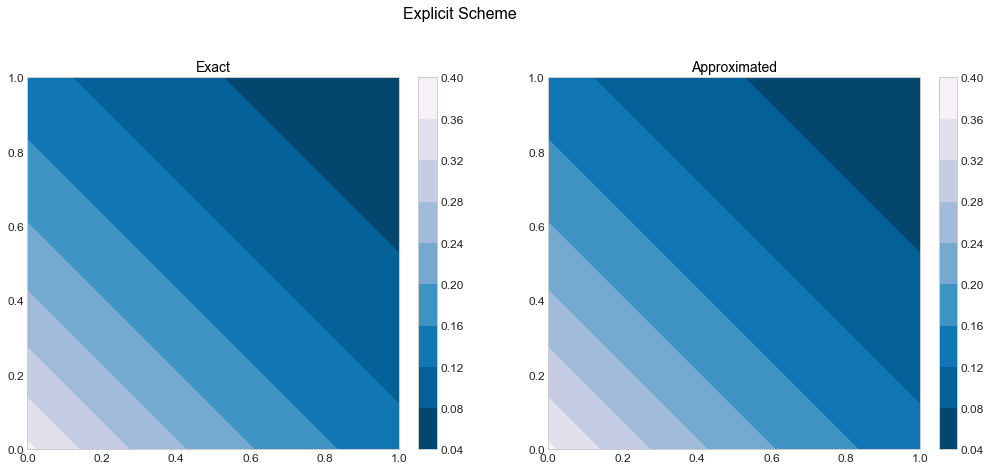

In [3]:
it=3
Norm=np.zeros(it, dtype=float)
N0=10;
Nt0=200;
N=np.asarray([N0*2**n for n in range(0,it)])
Nt=np.asarray([Nt0 for n in range(0,it)])
Ratio=np.zeros(it, dtype=float)
LOG=np.zeros(it, dtype=float)
CPU_Time=np.zeros(it, dtype=float)
# iteration
for n in range(it):
    if n != (it-1):
        start = timer()
        Norm[n],_,_ =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    else:
        start = timer()
        Norm[n], U_exact, U_Comp =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    if (n>0):
        Ratio[n]=Norm[n-1]/Norm[n]
        LOG[n]=math.log(Ratio[n],2)
        
data = pd.DataFrame({'Nx': N+1, 'Ny': N+1,'Nt': Nt+1, 'Norm': Norm, 'Ratio': Ratio, 'Log2': LOG, 'CPU Time': CPU_Time})
del it, Norm, N0, Nt0, N, Nt, Ratio, LOG, CPU_Time, n, start
display(data.style.format({'Norm': "{:.4e}"}))

Figs(U_exact, U_Comp, Scheme = 'Explicit Scheme', N = data.Nx.values[-1])

,Nx,Ny,Nt,Norm,Ratio,Log2,CPU Time
0,11,11,31,5.1111e-06,0.000000,0.000000,0.021770
1,21,21,61,1.1687e-06,4.373107,2.128659,0.094554
2,41,41,121,3.2532e-07,3.592588,1.845024,0.460864


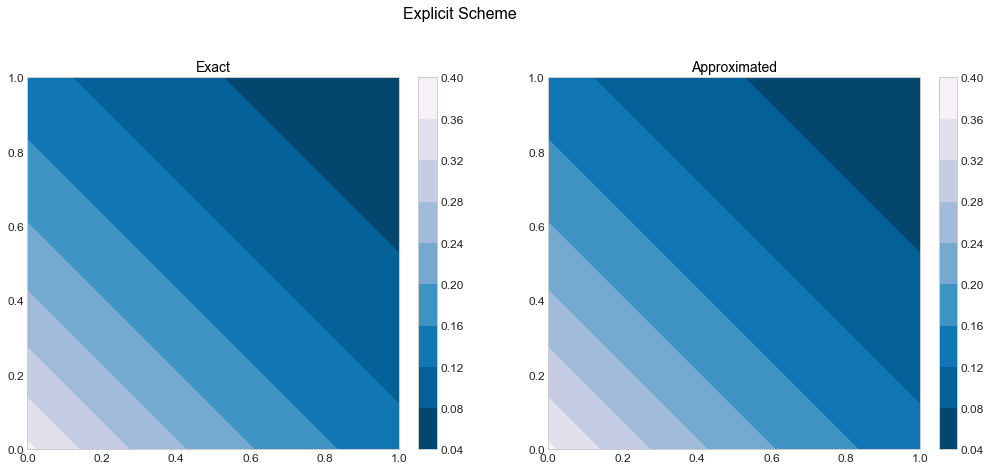

In [4]:
it=3
Norm=np.zeros(it, dtype=float)
N0=10;
Nt0=30;
N=np.asarray([N0*2**n for n in range(0,it)])
Nt=np.asarray([Nt0*2**n for n in range(0,it)])
Ratio=np.zeros(it, dtype=float)
LOG=np.zeros(it, dtype=float)
CPU_Time=np.zeros(it, dtype=float)
# iteration
for n in range(it):
    if n != (it-1):
        start = timer()
        Norm[n],_,_ =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    else:
        start = timer()
        Norm[n], U_exact, U_Comp =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    if (n>0):
        Ratio[n]=Norm[n-1]/Norm[n]
        LOG[n]=math.log(Ratio[n],2)
        
data = pd.DataFrame({'Nx': N+1, 'Ny': N+1,'Nt': Nt+1, 'Norm': Norm, 'Ratio': Ratio, 'Log2': LOG, 'CPU Time': CPU_Time})
del it, Norm, N0, Nt0, N, Nt, Ratio, LOG, CPU_Time, n, start
display(data.style.format({'Norm': "{:.4e}"}))

Figs(U_exact, U_Comp, Scheme = 'Explicit Scheme', N = data.Nx.values[-1])

What stands out from the tables is that the order of the method is 2 (in space and time). Moreover, consider the following experiment to test the stability condition.

In [5]:
it=3
Norm=np.zeros(it, dtype=float)
N0=10;
Nt0=8;
N=np.asarray([N0*2**n for n in range(0,it)])
Nt=np.asarray([Nt0*2**n for n in range(0,it)])
Ratio=np.zeros(it, dtype=float)
LOG=np.zeros(it, dtype=float)
CPU_Time=np.zeros(it, dtype=float)
# iteration
for n in range(it):
    if n != (it-1):
        start = timer()
        Norm[n],_,_ =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    else:
        start = timer()
        Norm[n], U_exact, U_Comp =Example01_ExSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    if (n>0):
        Ratio[n]=Norm[n-1]/Norm[n]
        LOG[n]=math.log(Ratio[n],2)
        
data = pd.DataFrame({'Nx': N+1, 'Ny': N+1,'Nt': Nt+1, 'Norm': Norm, 'Ratio': Ratio, 'Log2': LOG, 'CPU Time': CPU_Time})
del it, Norm, N0, Nt0, N, Nt, Ratio, LOG, CPU_Time, n, start
display(data.style.format({'Norm': "{:.4e}"}))

,Nx,Ny,Nt,Norm,Ratio,Log2,CPU Time
0,11,11,9,1.1310e+02,0.000000,0.000000,0.006793
1,21,21,17,6.6721e+12,0.000000,-35.779872,0.024796
2,41,41,33,7.3407e+36,0.000000,-79.864047,0.121298


### The Implicit Scheme

In [6]:
def Example01_ImSolver2D(N,Nt):
    # alpha, beta and gamma
    alpha=1/4
    beta=1/2
    gamma=1/4
    # N = the number of mesh points for space
    # Nt = the number of mesh points for time
    Nx=N
    Ny=N
    # [a,b], [c,d] and [T1,T2]
    a = 0.0
    b = 1.0
    c = 0.0
    d = 1.0
    T1 = 0.0
    T2 = 1.0
    # dx, dt, lambda_x^2 and lambda_y^2
    hx =(b-a)/Nx
    hy =(d-c)/Ny
    ht =(T2-T1)/Nt
    lx2=(ht/hx)**2
    ly2=(ht/hy)**2
    # Initial and Boundary Conditions
    C2 =lambda x,y: (1/2)*np.exp(x+y)
    g=lambda x,y: np.exp(-x-y)
    fa=lambda y,t: np.exp(-y-t)
    fb=lambda y,t: np.exp(-y-t-1)
    fc=lambda x,t: np.exp(-x-t)
    fd=lambda x,t: np.exp(-x-t-1)
    f=lambda x,y,t: np.exp(-t)*np.exp(-x)*np.exp(-y) - np.exp(-t)
    # the exact solution
    Ue= lambda x,y,t: np.exp(-x-y-t)
    #
    CC=np.zeros((Nx+1,Ny+1), dtype=float)
    U_exact=np.zeros((Nx+1,Ny+1), dtype=float)
    u0=np.zeros((Nx+1,Ny+1), dtype=float)
    u1=np.zeros((Nx+1,Ny+1), dtype=float)
    # discretizing [a,b], [c,d] and [T1,T2]
    xx=np.linspace(a, b, Nx+1)
    yy=np.linspace(c, d, Ny+1)
    tt=np.linspace(T1, T2, Nt+1)
    # u^{1}
    for j in range(Ny+1):
        # dicretizing c^2(x,y)
        CC[:,j] = C2(xx,yy[j]);
        # the Exact Solution
        U_exact[:,j] = Ue(xx,yy[j],T2);
        # u initial time value
        u0[:,j] = g(xx,yy[j]);
    # indeces
    mid=list(range(1,Nx))
    midp=[i+1 for i in mid]
    midm=[i-1 for i in mid]
    sup=list(range(1,Nx-1))
    sub=list(range(2,Nx))
    # Computing the solution at the first time step
    GG=lambda x,y: np.exp(-x-y)-np.exp(-x-y)*ht+(0.5)*(1+np.exp(-T1)*np.exp(-x)*np.exp(-y) - np.exp(-T1))*ht**2\
        +(1/6)*(-1+np.exp(-T1) - np.exp(-T1)*np.exp(-x)*np.exp(-y))*ht**3\
        +(1/24)*(1+np.exp(-T1)*np.exp(-x)*np.exp(-y) - np.exp(-T1))*ht**4
    # u^{1}
    for j in mid:
        u1[mid,j]=GG(xx[mid],yy[j])
    u1[0,:]=fa(yy,tt[1])
    u1[Nx,:]=fb(yy,tt[1])
    u1[:,0]=fc(xx,tt[1])
    u1[:,Ny]=fd(xx,tt[1])
    # for loop
    for n in range(1,Nt):
        u=np.zeros((Nx+1,Ny+1), dtype=float)
        X=np.zeros((Nx+1,Ny+1), dtype=float)
        # Part 1: Finding the values of X for current time step
        FA=fa(yy,tt[n+1])
        FB=fb(yy,tt[n+1])
        for j in range(1,Ny):
            # Matrix A_{j}
            Aj=diags([-alpha*CC[sub,j]*lx2,1+2*alpha*CC[mid,j]*lx2,-alpha*CC[sup,j]*lx2], [-1,0,1])
            # F_{j,k}
            F=beta*CC[mid,j]*(lx2*(u1[midp,j]+u1[midm,j])+ly2*(u1[mid,j+1]+u1[mid,j-1]))\
            +(2-2*beta*CC[mid,j]*(lx2+ly2))*u1[mid,j]\
            +gamma*CC[mid,j]*(lx2*(u0[midp,j]+u0[midm,j])+ly2*(u0[mid,j+1]+u0[mid,j-1]))\
            -(1+2*gamma*CC[mid,j]*(lx2+ly2))*u0[mid,j]+((ht**2)*f(xx[mid],yy[j],tt[n]))
            # b_j
            bj=np.zeros(len(mid), dtype=float)
            bj[0]=alpha*CC[1,j]*lx2*(-alpha*CC[0,j]*ly2*(FA[j-1]+FA[j+1])+(1+2*alpha*CC[0,j]*ly2)*FA[j])
            bj[Nx-2]=alpha*CC[Nx-1,j]*lx2*(-alpha*CC[Nx-1,j]*ly2*(FB[j-1]+FB[j+1])+(1+2*alpha*CC[Nx-1,j]*ly2)*FB[j])
            # X
            X[mid,j]=spsolve(Aj,F+bj)
            del Aj, bj
        # Part 2: Finding the values of Y for current time step
        FC= fc(xx,tt[n+1])
        FD= fd(xx,tt[n+1])
        for i in range(1,Nx):
            # Matrix A_{i}
            Ai=diags([-alpha*CC[i,sub]*ly2,1+2*alpha*CC[i,mid]*ly2,-alpha*CC[i,sup]*ly2], [-1,0,1])
            bi=np.zeros(len(mid), dtype=float)
            bi[0]=alpha*CC[i,1]*ly2*FC[i]
            bi[Ny-2]=alpha*CC[i,Ny-1]*ly2*FD[i]
            u[i,mid]=spsolve(Ai,X[i,mid]+bi)
            del Ai, bi
        # Boundaries
        u[0,:]=fa(yy,tt[n+1])
        u[Nx,:]=fb(yy,tt[n+1])
        u[:,0]=fc(xx,tt[n+1])
        u[:,Ny]=fd(xx,tt[n+1])
        u0=u1
        u1=u
    # the end of loops
    # Norm
    U_Comp = u
    Norm=np.max(np.abs(U_Comp-U_exact))
    return Norm, U_exact, U_Comp

,Nx,Ny,Nt,Norm,Ratio,Log2,CPU Time
0,11,11,201,5.9482e-06,0.000000,0.000000,1.056902
1,21,21,201,1.5367e-06,3.870818,1.952638,2.307304
2,41,41,201,4.0349e-07,3.808490,1.929219,5.075133


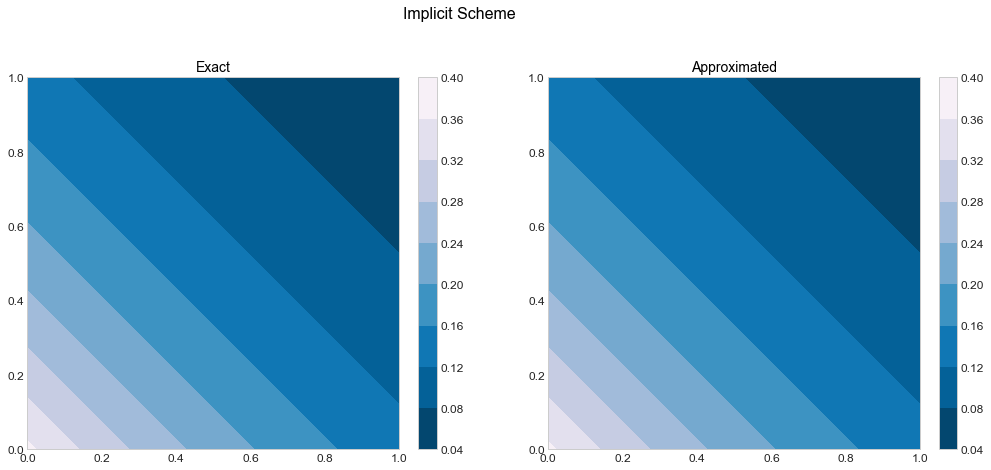

In [7]:
it=3
Norm=np.zeros(it, dtype=float)
N0=10
Nt0=200
N=np.asarray([N0*2**n for n in range(0,it)])
Nt=np.asarray([Nt0 for n in range(0,it)])
Ratio=np.zeros(it, dtype=float)
LOG=np.zeros(it, dtype=float)
CPU_Time=np.zeros(it, dtype=float)
# iteration
for n in range(it):
    if n != (it-1):
        start = timer()
        Norm[n],_,_ =Example01_ImSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    else:
        start = timer()
        Norm[n], U_exact, U_Comp =Example01_ImSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    if (n>0):
        Ratio[n]=Norm[n-1]/Norm[n]
        LOG[n]=math.log(Ratio[n],2)
        
data = pd.DataFrame({'Nx': N+1, 'Ny': N+1,'Nt': Nt+1, 'Norm': Norm, 'Ratio': Ratio, 'Log2': LOG, 'CPU Time': CPU_Time})
del it, Norm, N0, Nt0, N, Nt, Ratio, LOG, CPU_Time, n, start
display(data.style.format({'Norm': "{:.4e}"}))

Figs(U_exact, U_Comp, Scheme = 'Implicit Scheme', N = data.Nx.values[-1])

,Nx,Ny,Nt,Norm,Ratio,Log2,CPU Time
0,201,201,21,4.7600e-06,0.000000,0.000000,3.648533
1,201,201,41,8.8324e-07,5.389278,2.430092,7.455384
2,201,201,81,2.1607e-07,4.087687,2.031285,15.016336


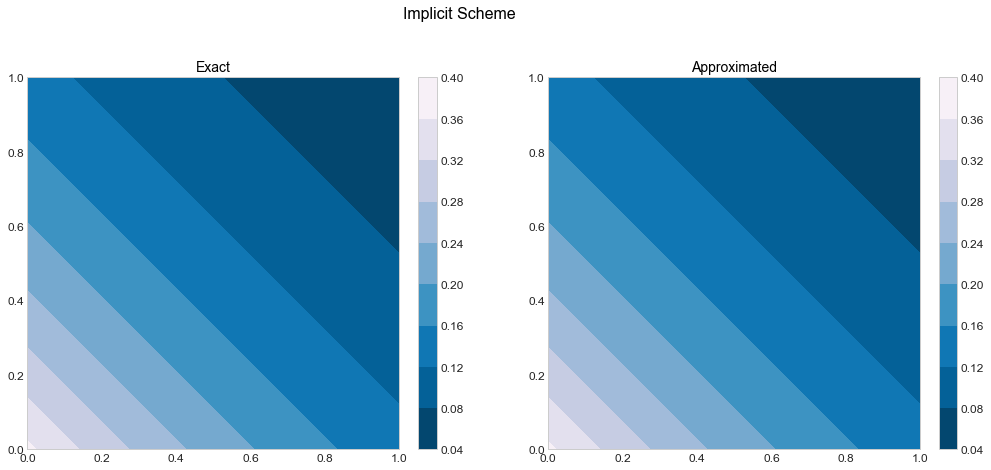

In [8]:
it=3
Norm=np.zeros(it, dtype=float)
N0=200
Nt0=20
N=np.asarray([N0 for n in range(0,it)])
Nt=np.asarray([Nt0*2**n for n in range(0,it)])
Ratio=np.zeros(it, dtype=float)
LOG=np.zeros(it, dtype=float)
CPU_Time=np.zeros(it, dtype=float)
# iteration
for n in range(it):
    if n != (it-1):
        start = timer()
        Norm[n],_,_ =Example01_ImSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    else:
        start = timer()
        Norm[n], U_exact, U_Comp =Example01_ImSolver2D(N[n],Nt[n])
        CPU_Time[n] = timer() - start
    if (n>0):
        Ratio[n]=Norm[n-1]/Norm[n]
        LOG[n]=math.log(Ratio[n],2)
        
data = pd.DataFrame({'Nx': N+1, 'Ny': N+1,'Nt': Nt+1, 'Norm': Norm, 'Ratio': Ratio, 'Log2': LOG, 'CPU Time': CPU_Time})
del it, Norm, N0, Nt0, N, Nt, Ratio, LOG, CPU_Time, n, start
display(data.style.format({'Norm': "{:.4e}"}))

Figs(U_exact, U_Comp, Scheme = 'Implicit Scheme', N = data.Nx.values[-1])

***